# Crater Detection using Deep Learning with PyTorch

## Model Selection

In [1]:
model_dict = {0: "faster", 1: "ssd", 2: "retina"}

We are using SSD in this Notebook, so we choose that model

In [2]:
model_num = 1

## Setting up

- Clone the [torchvision repository](https://github.com/pytorch/vision.git) and copy the helper scripts into the working directory.
    - references/detection/utils.py
    - references/detection/transforms.py
    - references/detection/coco_eval.py
    - references/detection/engine.py
    - references/detection/coco_utils.py
- Install cython, opencv, pycocotools and albumentations.

In [3]:
!git clone https://github.com/pytorch/vision.git --depth 1

Cloning into 'vision'...
remote: Enumerating objects: 991, done.
remote: Counting objects: 100% (991/991), done.
remote: Compressing objects: 100% (820/820), done.
remote: Total 991 (delta 210), reused 487 (delta 141), pack-reused 0
Receiving objects: 100% (991/991), 12.78 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [4]:
!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

## Dataset Loading

We're going to get our dataset from Kaggle.

In [5]:
!pip install -q kaggle

Uploading the Kaggle token and moving it to the required directory. The Kaggle token can be obtained by following the instructions in the article [here](https://www.kaggle.com/docs/api), under "Installation and Authentication".

In [6]:
from google.colab import files
files.upload()
print("done")

Saving kaggle.json to kaggle.json
done


In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Downloading the datasets and unzipping them

In [8]:
!kaggle datasets download -d lincolnzh/martianlunar-crater-detection-dataset

 78% 58.0M/74.0M [00:00<00:00, 75.5MB/s]
100% 74.0M/74.0M [00:00<00:00, 87.8MB/s]


In [9]:
!unzip martianlunar-crater-detection-dataset.zip
print("done")

Archive:  martianlunar-crater-detection-dataset.zip
  inflating: best.pt                 
  inflating: craters/test/images/010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg  
  inflating: craters/test/images/015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg  
  inflating: craters/test/images/019_png.rf.1930cd277f9bf0e3fa57f2dcfee0385f.jpg  
  inflating: craters/test/images/04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92.jpg  
  inflating: craters/test/images/mars_crater--100-_jpg.rf.a2ad5867efb2d73e86d9d980ca40a9fe.jpg  
  inflating: craters/test/images/mars_crater--108-_jpg.rf.9395f473f249e064dbfea078e2519a17.jpg  
  inflating: craters/test/images/mars_crater--116-_jpg.rf.2e550a693a8800808e68848484716b95.jpg  
  inflating: craters/test/images/mars_crater--117-_jpg.rf.b412b6593d102c5f9dda7bce79bb815c.jpg  
  inflating: craters/test/images/mars_crater--12-_jpg.rf.26060e7ca4ca8781bcaf011b9b70b7db.jpg  
  inflating: craters/test/images/mars_crater--25-_jpg.rf.a06bfa24b404b064ead471f56d636e0e.jpg  

## Imports

In [10]:
import os
import random
import time

import numpy as np

import torch
import torchvision
from torchvision.transforms import v2 as T

from engine import train_one_epoch, evaluate
import utils


from PIL import Image
import cv2

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from  sklearn.model_selection import KFold

## Setting up Dataset

- The dataset is in YOLO format - normalized x_center, y_center, width, height.
- TorchVision Object Detection Models require the target in PASCAL-VOC format - x_min, y_min, x_max, y_max.
- We need to convert the dataset from YOLO format to PASCAL-VOC format.
- All Dataset classes should have the following methods as per the [PyTorch documentation](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html):
    - __len__ - returns the length of the dataset.
    - __getitem__ - returns a sample from the dataset at the given index.


In [11]:
class CratersDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(self.root, "labels"))))
        # two classes: Background and Crater
        self.classes = ['Background', 'Crater']

    def format_annotations(self, annotations, from_format, to_format, image_shape):
        if from_format == "yolo" and to_format == "pascal_voc":
            # yolo format: [class_id, x_center, y_center, width, height] (where x_center, y_center, width, height are normalized)
            # coco format: [x_min, y_min, x_max, y_max]
            # annotations parameter is of the form [[class_id, x_center, y_center, width, height], ...]
            # we will return only the coordinates
            # this is because we have only one class, so we don't need the class_id

            # here, the x_center and width are being multiplied by the width of the image, thus scaling them to the image size
            # similarly, the y_center and height are being multiplied by the height of the image, thus scaling them to the image size
            xw = annotations[:, (1,3)] * image_shape[1]
            yh = annotations[:, (2,4)] * image_shape[0]
            # now, we can calculate the x_min, y_min, x_max, y_max
            x_min = xw[:, 0] - xw[:, 1] / 2 # x_min is of the form [x_min1, x_min2, ...] for each row in the labels
            y_min = yh[:, 0] - yh[:, 1] / 2
            x_max = xw[:, 0] + xw[:, 1] / 2
            y_max = yh[:, 0] + yh[:, 1] / 2
            return np.column_stack((x_min, y_min, x_max, y_max))

    def __getitem__(self, idx):
        # load images and annotations
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annotation_path = os.path.join(self.root, "labels", self.annotations[idx])

        # read the image, convert colorspace to BGR, normalize pixel values to [0, 1]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = img / 255.0
        # convert image to double
        img = img.astype(np.float32)

        # get the annotations file.
        # if the file is empty, set the class_id to 0 and the coordinates to the left top corner with area 0
        # if the file is not empty, read the annotations, convert them to coco format and set class_id to 1
        if os.path.getsize(annotation_path) != 0:
          annotations = np.loadtxt(annotation_path, delimiter=" ", ndmin=2) # ndmin is the minimum number of dimensions the resulting array should have
          bounding_box_coords = self.format_annotations(annotations, from_format="yolo", to_format="pascal_voc", image_shape=img.shape)

          # convert to tensor with shape [number_of_detected_objects, 4]
          # number_of_detected_objects is the number of rows in the bounding_box_coords or len(bounding_box_coords)
          # 4 is the number of columns in the bounding_box_coords

          number_of_detected_objects = len(bounding_box_coords)
          bounding_box_coords = torch.as_tensor(bounding_box_coords, dtype=torch.float32)
          bounding_box_coords = bounding_box_coords.to(torch.float32)

          # create a tensor of class_ids with shape [number_of_detected_objects]
          class_ids = torch.ones((number_of_detected_objects,), dtype=torch.int64)

          # craters are not likely to occur in close proximity, so we can set the iscrowd flag to 0
          iscrowd = torch.zeros((number_of_detected_objects,), dtype=torch.int64)

        else:
          # bounding_box_coords = torch.zeros((0, 4), dtype=torch.float32)
          # class_ids = torch.zeros((1,), dtype=torch.int64)
          # iscrowd = torch.zeros((1,), dtype=torch.int64)
          bounding_box_coords = torch.tensor([[0,0, img.shape[1], img.shape[0]]], dtype=torch.float32)
          bounding_box_coords = bounding_box_coords.to(torch.float32)
          iscrowd = torch.zeros((1,), dtype=torch.int64)
          class_ids = torch.zeros((1,), dtype=torch.int64)

        # the function requires a tuple be returned containing the image and the target
        target = {}
        target["boxes"] = bounding_box_coords
        target["labels"] = class_ids
        target["image_id"] = idx
        target["iscrowd"] = iscrowd

        # convert the image to a tensor
        if self.transforms is not None:
          sample = self.transforms(image=img, bboxes=target["boxes"], labels=class_ids)
          img = sample["image"]
          target["boxes"] = torch.as_tensor(sample["bboxes"], dtype=torch.float32).to(torch.float32)
          target["labels"] = torch.as_tensor(sample["labels"], dtype=torch.int64)
          # if there are no annotations, we've set the bounding box coords to have dimensionality of 1. we need to set these values in the target
          if target["boxes"].dim() == 1:
              # target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
              # target["labels"] = torch.zeros(0, dtype=torch.int64)
              # target["iscrowd"] = torch.zeros((0,), dtype=torch.int64)
              target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32).to(torch.float32)
              target['labels'] = torch.zeros((1,), dtype=torch.int64)


        area = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0]) # area = height * width
        target["area"] = area

        return img, target

    def __len__(self):
        return len(self.imgs)

## The Models

We will use a number of models from the TorchVision library. The models are pre-trained on the COCO dataset. We will simply finetune them.

Models used:
- Faster R-CNN
- SSDLite MobileNetV3
- RetinaNet


In [12]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# model.eval()

In [13]:
# all_models = torchvision.models.list_models()
# print(all_models)

## Data Augmentations

In [32]:
def get_transform(train):
    if train:
        return A.Compose([
            A.Blur(p=0.01, blur_limit=(3, 7)),
            # A.MedianBlur(p=0.01, blur_limit=(3, 7)),
            A.ToGray(p=0.01),
            # A.CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8)),
            # A.RandomCrop(width=256, height=256),
            # A.HorizontalFlip(p=0.5),
            # A.RandomBrightnessContrast(p=0.2),
            # A.RandomGamma(p=0.2),
            ToTensorV2(p=1.0) # convert the image to a tensor and p, the probability of applying the transform, is set to 1.0
        ],
        bbox_params={"format": "pascal_voc", "label_fields": ["labels"], "min_visibility": 0.3}) # the format is the format of the bounding boxes, label_fields is the field in the target that contains the labels, min_visibility is the minimum fraction of the bounding box that needs to be visible after the transform
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ],
        bbox_params={"format": "pascal_voc", "label_fields": ["labels"], "min_visibility": 0.5})

## Resetting Weights

This function re-initializes the weights of the model. It is called before the model is trained to ensure a clean start.

In [33]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

## Training the Model

#### Setting the device and classes

In [34]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# classes: background, crater
num_classes = 2

There are only 98 images in the training set and 26 in the validation set. This is a very small dataset. We will use fine-tuning to train the model. We will only train the classifier and not the backbone. The backbone is already pre-trained on the COCO dataset.

The validation set is used to evaluate the model after each epoch. The model with the best validation loss is saved.

In [35]:
# number of epochs
num_epochs = 1 # for testing

#### Loading the Datasets and Dataloaders

In [36]:
# initialize the datasets
dataset = CratersDataset("/content/craters/train", get_transform(train=True))
dataset_validation = CratersDataset("/content/craters/valid", get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_validation = torch.utils.data.DataLoader(
    dataset_validation, batch_size=16, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

## Training functions



In [37]:
from functools import partial
def get_model(num_classes, model_ind=0, weights="DEFAULT"):
  """
  model_inds:
  0: fasterrcnn_resnet50_fpn
  1: ssd320lite_mobilenetv3
  2: retinanet_resnet50_fpn
  """

  if model_ind == 0:
    # load a pre-trained model for classification
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # the roi heads are the heads for the region of interest.
    # it includes the box predictor.
    # the box predictor includes the classification score, which is the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

  if model_ind == 1:
      model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights="DEFAULT", pretrained=True)
      in_channels = torchvision.models.detection._utils.retrieve_out_channels(model.backbone, (320, 320))
      num_anchors = model.anchor_generator.num_anchors_per_location()
      print("number of anchors:", num_anchors)
      norm_layer  = partial(torch.nn.BatchNorm2d, eps=0.001, momentum=0.03)

      model.head.classification_head = torchvision.models.detection.ssdlite.SSDLiteClassificationHead(in_channels, num_anchors, num_classes, norm_layer)

  if model_ind == 2:
        model = torchvision.models.detection.retinanet_resnet50_fpn_v2(
        weights="DEFAULT", pretrained=True
    )
        num_anchors = model.head.classification_head.num_anchors
        model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetClassificationHead(
          in_channels=256, # in line with
          num_anchors=num_anchors,
          num_classes=num_classes,
          norm_layer=partial(torch.nn.GroupNorm, 32)
    )

  return model

In [38]:
def build_optimizer_and_lr_scheduler(model, lr=0.005, momentum=0.9, weight_decay=0.0005, step_size=10, gamma=0.1):
  params = [p for p in model.parameters() if p.requires_grad] # get all the parameters that require a gradient
  optimizer = torch.optim.SGD( # stochastic gradient descent
      params,
      lr=lr, # learning rate
      momentum=momentum, # momentum is a parameter that accelerates the gradient descent in the relevant direction
      weight_decay=weight_decay # weight decay is a regularization term that penalizes large weights
  )

  # the learning rate scheduler decreases the learning rate by a factor of gamma every step_size epochs
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

  return optimizer, lr_scheduler

In [39]:
def training_time(model, num_epochs, optimizer, lr_scheduler, data_loader, data_loader_validation, device, print_freq=10):
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_validation, device=device)

  print("training complete.")

## Preliminary Training

Testing the generalized code

In [40]:
# testing generalized code
# initialize the datasets
dataset = CratersDataset("/content/craters/train", get_transform(train=True))
dataset_validation = CratersDataset("/content/craters/valid", get_transform(train=False))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_validation = torch.utils.data.DataLoader(
    dataset_validation, batch_size=16, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

num_epochs=1

model = get_model(num_classes, model_num)
model.apply(reset_weights)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)
optimizer, lr_scheduler = build_optimizer_and_lr_scheduler(model)
training_time(model,num_epochs,optimizer,lr_scheduler,data_loader,data_loader_validation,device)


number of anchors: [6, 6, 6, 6, 6, 6]
Epoch: [0]  [0/7]  eta: 0:00:20  lr: 0.000838  loss: 10.8906 (10.8906)  bbox_regression: 5.6888 (5.6888)  classification: 5.2018 (5.2018)  time: 2.9128  data: 0.2000  max mem: 1587
Epoch: [0]  [6/7]  eta: 0:00:00  lr: 0.005000  loss: 11.0544 (10.3886)  bbox_regression: 6.5379 (5.9710)  classification: 4.9242 (4.4177)  time: 0.7297  data: 0.1908  max mem: 1612
Epoch: [0] Total time: 0:00:05 (0.7299 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:01  model_time: 0.1857 (0.1857)  evaluator_time: 0.4553 (0.4553)  time: 0.9364  data: 0.2757  max mem: 1612
Test:  [1/2]  eta: 0:00:00  model_time: 0.1111 (0.1484)  evaluator_time: 0.2381 (0.3467)  time: 0.7537  data: 0.2418  max mem: 1612
Test: Total time: 0:00:01 (0.7554 s / it)
Averaged stats: model_time: 0.1111 (0.1484)  evaluator_time: 0.2381 (0.3467)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100

### K-Fold cross validation

We put all the training and validation images in one folder and use the KFold class from the scikit-learn library to split the images into training and validation sets. We then train the model on each fold and assess the predictive ability of each model.

This directory is the `working` directory. The `images` directory contains the images. The `labels` directory contains the labels.

Here, we are creating the `working` directory by copying the content `images/` and `labels/` directories from the `valid/` and `train/` directories into a new directory. The directory structure is as follows:

```sh
content
  - craters
    - train
      - images
      - labels
    - test
      - images
      - labels
    - valid
      - images
      - labels
    - working
      - images
      - labels
```

In [41]:
!rm -rf /content/craters/working/
!mkdir -p /content/craters/working/images /content/craters/working/labels

!cp -a /content/craters/train/images/. /content/craters/working/images
!cp -a /content/craters/train/labels/. /content/craters/working/labels
!cp -a /content/craters/valid/images/. /content/craters/working/images
!cp -a /content/craters/valid/labels/. /content/craters/working/labels

Here, we are setting up the K-folds with $k = 5$ to test the predictive ability of each model.

In [44]:
num_epochs = 5

kfolds = 5

kfold = KFold(n_splits=kfolds, shuffle=True)

model = get_model(num_classes=2, model_ind=model_num)

number of anchors: [6, 6, 6, 6, 6, 6]


In [45]:
# initialize the datasets
dataset = CratersDataset("/content/craters/working/", get_transform(train=True))
dataset_validation = CratersDataset("/content/craters/working", get_transform(train=False))

#### K-fold validation

In [46]:
for fold, (train_ids, validation_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD NUMBER {fold}')
    print('--------------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_ids)

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, sampler=train_subsampler, num_workers=0,
        collate_fn=utils.collate_fn)

    data_loader_validation = torch.utils.data.DataLoader(
        dataset_validation, batch_size=8, sampler=validation_subsampler, num_workers=0,
        collate_fn=utils.collate_fn)

    # use the get_model function to get the model
    model = get_model(num_classes, model_num)

    model.apply(reset_weights)

    # move model to the right device
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad] # get all the parameters that require a gradient
    optimizer = torch.optim.SGD( # stochastic gradient descent
        params,
        lr=0.005, # learning rate
        momentum=0.9, # momentum is a parameter that accelerates the gradient descent in the relevant direction
        weight_decay=0.0005 # weight decay is a regularization term that penalizes large weights
    )

    # the learning rate scheduler decreases the learning rate by a factor of gamma every step_size epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the validation dataset
        evaluate(model, data_loader_validation, device=device)

    print("training complete.")

FOLD NUMBER 0
--------------------------------
number of anchors: [6, 6, 6, 6, 6, 6]
Epoch: [0]  [ 0/13]  eta: 0:00:03  lr: 0.000421  loss: 12.3758 (12.3758)  bbox_regression: 7.3070 (7.3070)  classification: 5.0688 (5.0688)  time: 0.2766  data: 0.0933  max mem: 1612
Epoch: [0]  [10/13]  eta: 0:00:00  lr: 0.004584  loss: 10.5145 (10.4001)  bbox_regression: 5.9902 (5.9891)  classification: 4.2921 (4.4109)  time: 0.2048  data: 0.0949  max mem: 1612
Epoch: [0]  [12/13]  eta: 0:00:00  lr: 0.005000  loss: 10.5145 (10.7360)  bbox_regression: 6.2570 (6.4094)  classification: 4.2396 (4.3266)  time: 0.2108  data: 0.0949  max mem: 1612
Epoch: [0] Total time: 0:00:02 (0.2111 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:00  model_time: 0.0340 (0.0340)  evaluator_time: 0.1120 (0.1120)  time: 0.2456  data: 0.0897  max mem: 1612
Test:  [3/4]  eta: 0:00:00  model_time: 0.0335 (0.0565)  evaluator_time: 0.1120 (0.0982)  time: 0.2381  data: 0.0758  max mem: 1612
Test: Total time: 0:00

## Generalizing K-fold validation code

In [47]:
def k_fold_training(dataset, dataset_validation,kfolds,num_epochs,model,optimizer, lr_scheduler, device, print_freq=10):
  kfold = KFold(n_splits=kfolds, shuffle=True)
  for fold, (train_ids, validation_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD NUMBER {fold}')
    print('--------------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    validation_subsampler = torch.utils.data.SubsetRandomSampler(validation_ids)

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, sampler=train_subsampler, num_workers=0,
        collate_fn=utils.collate_fn)

    data_loader_validation = torch.utils.data.DataLoader(
        dataset_validation, batch_size=8, sampler=validation_subsampler, num_workers=0,
        collate_fn=utils.collate_fn)


    model.apply(reset_weights)
    # move model to the right device
    model.to(device)


    training_time(model=model,num_epochs=num_epochs,optimizer=optimizer,lr_scheduler=lr_scheduler,data_loader=data_loader,data_loader_validation=data_loader_validation,device=device)

    print("training complete.")

In [48]:
model = get_model(num_classes=2, model_ind=model_num)
optimizer, lr_scheduler = build_optimizer_and_lr_scheduler(model=model)

dataset = CratersDataset("/content/craters/working/", get_transform(train=True))
dataset_validation = CratersDataset("/content/craters/working", get_transform(train=False))

kfolds = 2
num_epochs = 1
k_fold_training(dataset,dataset_validation,kfolds,num_epochs,model,optimizer,lr_scheduler,device)


number of anchors: [6, 6, 6, 6, 6, 6]
FOLD NUMBER 0
--------------------------------
Epoch: [0]  [0/8]  eta: 0:00:01  lr: 0.000719  loss: 14.6293 (14.6293)  bbox_regression: 8.4874 (8.4874)  classification: 6.1419 (6.1419)  time: 0.2216  data: 0.1123  max mem: 1612
Epoch: [0]  [7/8]  eta: 0:00:00  lr: 0.005000  loss: 10.7426 (11.4864)  bbox_regression: 5.9205 (6.4763)  classification: 4.6476 (5.0100)  time: 0.2146  data: 0.1019  max mem: 1612
Epoch: [0] Total time: 0:00:01 (0.2148 s / it)
creating index...
index created!
Test:  [0/8]  eta: 0:00:01  model_time: 0.0330 (0.0330)  evaluator_time: 0.1127 (0.1127)  time: 0.2288  data: 0.0737  max mem: 1612
Test:  [7/8]  eta: 0:00:00  model_time: 0.0393 (0.0395)  evaluator_time: 0.1511 (0.1645)  time: 0.3437  data: 0.1295  max mem: 1612
Test: Total time: 0:00:02 (0.3440 s / it)
Averaged stats: model_time: 0.0393 (0.0395)  evaluator_time: 0.1511 (0.1645)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (A

## Visualization

In [49]:
def draw_bounding_box(image, target):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(6, 6)
    ax.imshow(image.permute(1, 2, 0)) # pytorch represents images as tensors in the form [channels, height, width]. imshow requires the image to be in the form [height, width, channels].

    for box in target["boxes"]:
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = plt.Rectangle((x, y), width, height, fill=False, edgecolor="red", linewidth=2)
        ax.annotate("Crater", (x, y), color="red", fontsize=12, weight="bold", va="top")
        ax.add_patch(rect)
    plt.show()

#### Testing Visualization code on Working dataset

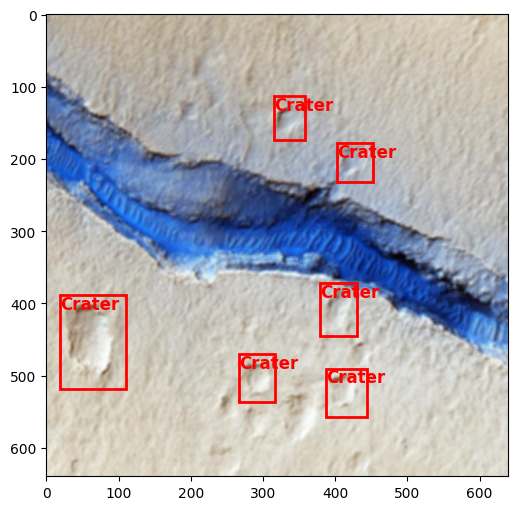

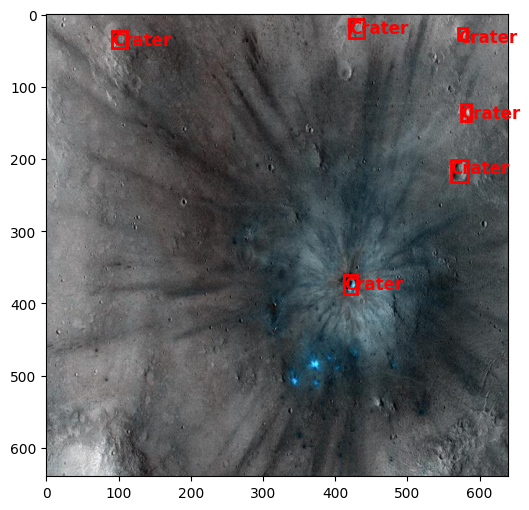

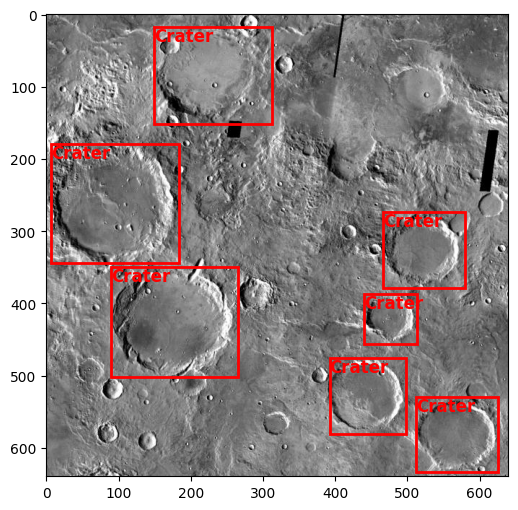

In [50]:
dataset = CratersDataset('/content/craters/working', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    draw_bounding_box(img, target)

## Final Training Setup

We begin by setting the number of epochs and number of classes.

In [51]:
number_of_epochs = 25

number_of_classes = 2

Next, we initialize the datasets and load them.

In [52]:
# initialize datasets

dataset = CratersDataset("/content/craters/working", get_transform(train=True))
dataset_test = CratersDataset("/content/craters/test", get_transform(train=False))

# define training and testing data loaders

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

We first call the `get_model` function with the model number. We reset the weights, set the device to use the GPU and send the model to the GPU.

In [53]:
# get model
model = get_model(number_of_classes, model_num)

model.apply(reset_weights)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)

number of anchors: [6, 6, 6, 6, 6, 6]


SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

Setting the parameters

In [54]:
optimizer, lr_scheduler = build_optimizer_and_lr_scheduler(model=model)

Creating arrays to save the results and a variable denoting the best epoch

In [55]:
result_mAP = []
best_epoch = None
best_results = None

Training the final model:

In [56]:
# training

for epoch in range(number_of_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset evaluate is a function from the engine.py
    # file that returns the result of the evaluation.
    result = evaluate(model, data_loader_test, device=device)
    # the coco_eval attribute is a dictionary that contains the evaluation
    # results for the bounding box detection. stats[1] is the mean average
    # precision (mAP) for the bounding box detection.
    result_mAP.append(result.coco_eval["bbox"].stats[1])
    # if the mAP is greater than the mAP of the previous epoch, save the model.
    if best_epoch is None or result_mAP[-1] > result_mAP[best_epoch]:
        best_epoch = int(epoch)
        best_results = result.coco_eval["bbox"]
        torch.save(model.state_dict(), f"best_{model_dict[model_num]}_{best_epoch}.pth")
        print(f"model saved at epoch {best_epoch} to best_{model_dict[model_num]}_{best_epoch}.pth")
    print(f"mAP: {result_mAP[-1]}")

Epoch: [0]  [ 0/16]  eta: 0:00:03  lr: 0.000338  loss: 12.3361 (12.3361)  bbox_regression: 5.9818 (5.9818)  classification: 6.3542 (6.3542)  time: 0.2199  data: 0.1159  max mem: 1612
Epoch: [0]  [10/16]  eta: 0:00:01  lr: 0.003668  loss: 11.7335 (11.8027)  bbox_regression: 6.0250 (6.6317)  classification: 4.9064 (5.1710)  time: 0.2026  data: 0.0960  max mem: 1612
Epoch: [0]  [15/16]  eta: 0:00:00  lr: 0.005000  loss: 10.5586 (11.3729)  bbox_regression: 5.9818 (6.4311)  classification: 4.5039 (4.9417)  time: 0.2034  data: 0.0972  max mem: 1612
Epoch: [0] Total time: 0:00:03 (0.2037 s / it)
creating index...
index created!
Test:  [ 0/19]  eta: 0:00:02  model_time: 0.0231 (0.0231)  evaluator_time: 0.0705 (0.0705)  time: 0.1188  data: 0.0238  max mem: 1612
Test:  [18/19]  eta: 0:00:00  model_time: 0.0526 (0.0492)  evaluator_time: 0.0705 (0.0689)  time: 0.1573  data: 0.0372  max mem: 1612
Test: Total time: 0:00:02 (0.1574 s / it)
Averaged stats: model_time: 0.0526 (0.0492)  evaluator_time: 

Displaying the best result:

In [57]:
print("best:")
print(result_mAP[best_epoch])
print(best_epoch)

best:
0.09868113089561567
23


In [58]:
print(best_results.stats)
best_results.summarize()

[4.91618752e-02 9.86811309e-02 4.46497106e-02 1.03856540e-05
 1.44247600e-02 2.10896194e-01 2.51655629e-02 7.01986755e-02
 1.00000000e-01 4.16666667e-03 5.69444444e-02 3.48387097e-01]
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Recall 

Downloading the best model locally

In [59]:
from google.colab import files
files.download(f'/content/best_{model_dict[model_num]}_{best_epoch}.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generating and saving a precision recall curve for the best model

Shape of precisions array: (10, 101, 1, 4, 3)


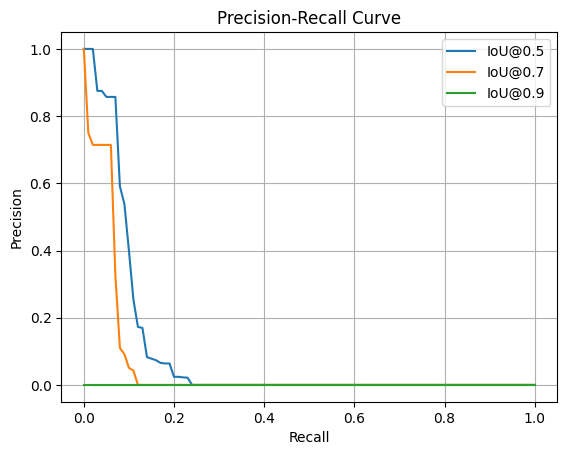

In [60]:
import matplotlib.pyplot as plt

best_stats = best_results.eval

# extract precision and recall values
precisions = best_stats['precision']
# this returns an array containing the precisions with the following dimensions:
# T: len([.5:.05:1.0]) the 10 IoU Thresholds
# R: len([0:0.01:1])  the 100 Recall Thresholds
# K: The number of class ids
# A: A=4 which corresponds to the object area ranges
# M: max detections
print("Shape of precisions array:", precisions.shape)

# select the precision at different IoU thresholds

pr_5 = precisions[0, :, 0, 0, 2] # data for IoU@0.5
pr_7 = precisions[4, :, 0, 0, 2] # data for IoU@0.7
pr_9 = precisions[8, :, 0, 0, 2] # data for IoU@0.9

recall_thresholds = np.arange(0, 1.01, 0.01)  # recall thresholds are from 0 to 1 with step size of 0.01

# Plot precision-recall curves for different IoU thresholds
plt.plot(recall_thresholds, pr_5, label='IoU@0.5')
plt.plot(recall_thresholds, pr_7, label='IoU@0.7')
plt.plot(recall_thresholds, pr_9, label='IoU@0.9')

# plot precision-recall curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(f'{model_dict[model_num]}_precision_recall_curve.png')

# Show the plot (optional)
plt.show()

In [61]:
from google.colab import files
files.download(f'/content/{model_dict[model_num]}_precision_recall_curve.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>